# Flowers Classification

The task in this machine learning problem is to predict the correct flower category from an image. The flowers are commonly occuring flowers in United Kingdom such as water lily and petunia. 

This notebook is based in part on the work of the github repository https://github.com/osemars/102-Flower-Classification-by-Transfer-Learning

For information about the dataset used, see 
https://www.robots.ox.ac.uk/~vgg/data/flowers/102/

## Settings

In [42]:
# Path to training and test data
DATA_PATH = '../data'

# Number of training epochs
NUM_EPOCHS = 5

# Define the batch size
BATCH_SIZE = 32

## Setup

See the README.md file for system requirements and installation instructions.

### Imports

In [3]:
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms


### Observe available device

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Download and prepare the dataset

Download the dataset or use from previously downloaded cache. Also define transformations to apply to the data.

In [5]:
# TODO: Define your transforms for the training, validation, and testing sets
train_data_transforms = transforms.Compose ([transforms.RandomRotation (30),
                                             transforms.RandomResizedCrop (224),
                                             transforms.RandomHorizontalFlip (),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])
valid_data_transforms = transforms.Compose ([transforms.Resize (256),
                                             transforms.CenterCrop (224),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])
test_data_transforms = transforms.Compose ([transforms.Resize (256),
                                             transforms.CenterCrop (224),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])

In [6]:
# Download and extract the Flowers dataset
# Downloads a .tgz file (345MB). Takes about 4 minutes on a typical connection.
trainset = torchvision.datasets.Flowers102(root=DATA_PATH, split="train",
                                      download=True, transform=train_data_transforms)

valset = torchvision.datasets.Flowers102(root=DATA_PATH, split="val",
                                      download=True, transform=valid_data_transforms)

testset = torchvision.datasets.Flowers102(root=DATA_PATH, split="test",
                                      download=True, transform=test_data_transforms)


In [7]:
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(valset, batch_size = 64, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

In [8]:
# The number of classes
class_num = 102

## About the dataset

Total number of images: 8189
Nr of images in the training set: 1020
Nr of images in the validation set: 1020
Nr of images in the test set: 6149


/tmp/ipykernel_1153772/3064464271.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid ra

Each sample is of type: <class 'tuple'>
Each image is of type: <class 'torch.Tensor'> and has dimensions torch.Size([3, 224, 224])


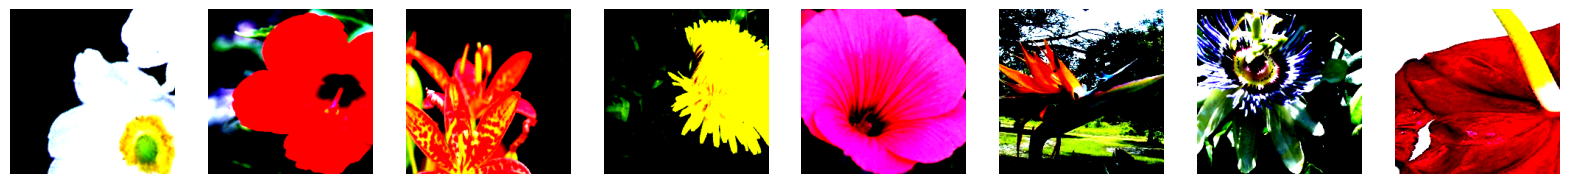

In [9]:
# Investigate the data
import random as rand

print(f"Total number of images: {len(trainset)+len(valset)+len(testset)}")
print(f"Nr of images in the training set: {len(trainset)}")
print(f"Nr of images in the validation set: {len(valset)}")
print(f"Nr of images in the test set: {len(testset)}")

# Display some random images from the training set
n_images = 8
img_indexes = rand.sample(range(0,len(trainset)), n_images)

# TODO: supress Matplotlib warnings
fig, ax = plt.subplots(1,n_images, figsize=(20, 20))
fig.show()
for i, idx in enumerate(img_indexes):
    sample = trainset[idx]
    img = sample[0]
    ax[i].imshow(img.permute(1,2,0))
    ax[i].axis('off')
fig.canvas.draw()

print(f"Each sample is of type: {type(sample)}")
img = sample[0]
print(f"Each image is of type: {type(img)} and has dimensions {img.shape}")

## Solution

### ML approach

- We split training set ??? for training and validation.
- We use a CNN model to train on the training set and evaluate on the evaluations set.
- We will use the VGG19 architecture, a CNN model with 19 layers.

In [19]:
# TODO: Build and train your network
# Downloading a pre-trained VGG16 model takes about 1 min
model = models.vgg19(weights="VGG19_Weights.DEFAULT")
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [31]:
# We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward() on features layer
for param in model.features.parameters():
    param.requires_grad = False
    
# update the classifier layer
classifier = nn.Sequential(
          nn.Linear(in_features=25088, out_features=4096, bias=True),
          nn.ReLU(),
          nn.Dropout (p = 0.5),
          nn.Linear(in_features=4096, out_features=2048, bias=True),
          nn.ReLU(),
          nn.Dropout (p = 0.5),
          nn.Linear(in_features=2048, out_features=class_num, bias=True)
        )
model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Define the training algorithm

In [37]:
def train(num_epochs = 1, learning_rate = 0.001):

    training_losses = np.zeros(num_epochs)
    training_metrics = np.zeros(num_epochs)
    validation_losses = np.zeros(num_epochs)
    validation_metrics = np.zeros(num_epochs)
    #accuracy_val = []
    #accuracy_train = []

    model.to(device)

    optimizer = optim.Adam (model.classifier.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss()

    for e in range(num_epochs):
        
        model.train()

        train_loss = 0.0

        for data, labels in train_dataloader:
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = model.forward(data)

            loss = criterion(outputs, labels)
            training_losses[e] = loss.item()

            loss.backward()

            optimizer.step()

            train_loss += loss.item()
            
        model.eval()
        valid_loss = 0.0

        for data, labels in valid_dataloader:
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()

            outputs = model.forward(data)

            valid_loss += criterion(outputs, labels).item()
        
        validation_losses[e] = valid_loss / len(valid_dataloader)
        print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_dataloader)} \t\t Validation Loss: {valid_loss / len(valid_dataloader)}')

    return training_losses, validation_losses

### Train the model

In [43]:
import datetime as dt

# Set hyperparameters
learning_rate = 0.001

cost_train = []
accuracy_val = []
accuracy_train = []

start = dt.datetime.now()

training_losses, validation_losses = train(NUM_EPOCHS, learning_rate)

print(f"Training duration ", str(dt.datetime.now() - start))

Epoch 1 		 Training Loss: 5.0594993978738785 		 Validation Loss: 3.72781939804554
Epoch 2 		 Training Loss: 3.676256999373436 		 Validation Loss: 2.82644060254097
Epoch 3 		 Training Loss: 3.0390350222587585 		 Validation Loss: 2.192073732614517
Epoch 4 		 Training Loss: 2.592741012573242 		 Validation Loss: 1.7907479330897331
Epoch 5 		 Training Loss: 2.217509925365448 		 Validation Loss: 1.6056363880634308
Training duration  0:26:38.223786


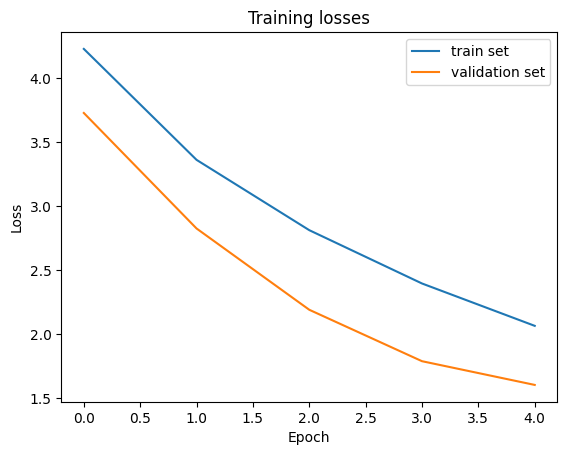

In [44]:
# View the training metrics
plt.plot(training_losses, label='train set')
plt.plot(validation_losses, label='validation set')
plt.title('Training losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('ploz')
plt.show()

### View the training results

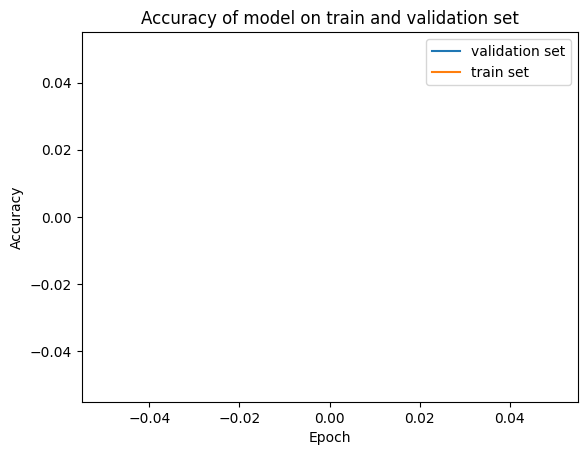

In [40]:
plt.plot(accuracy_val, label='validation set')
plt.plot(accuracy_train, label='train set')
plt.title('Accuracy of model on train and validation set')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('ploz')
plt.show()

## Evaluation

In [41]:
# TODO: Do validation on the test set
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for data, labels in loader:
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
                
            scores = model(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == labels).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 

check_accuracy(test_dataloader, model)

Got 2861 / 6149 with accuracy 46.53


In [51]:
# Save the entire PyTorch model to a file
name = "vgg19"
model_path = f"models/trained_model_{name}.pth"
torch.save(model, model_path)

In [52]:
# Verify loading the saved trained model
trained_model = torch.load(model_path)
print(trained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1